### Decision Tree Model Tuning for 2016 - 2020 Data (exports)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import modelinghelper as helper

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from adspy_shared_utilities import plot_feature_importances
#from adspy_shared_utilities import plot_decision_tree

import joblib
import os
from datetime import datetime

# supress future warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
#set up random seed
rng = 42

# set up folder to save results
output_path = 'export_run4_TargetEncoding_gridsearchCV'
dataset = 'export'

if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print("Folder already exists")

# file name
prefix = f'{output_path}/{dataset}'

Folder already exists


In [3]:
# read in data
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

In [4]:
df['ship_date_mm'] = df['ship_date_mm'].astype(str)

In [5]:
df.describe()

,control_number,qty,value,qty_new,ship_date_yyyy
count,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06
mean,2.018142e+09,1.955213e+06,9.658016e+03,1.954949e+06,2.017558e+03
std,1.263350e+06,2.644078e+08,9.355053e+05,2.644078e+08,1.279415e+00
min,2.014539e+09,-1.000000e+00,0.000000e+00,-1.000000e+00,2.016000e+03
25%,2.016978e+09,1.500000e+00,5.100000e+01,1.000000e+00,2.016000e+03
50%,2.017984e+09,9.000000e+00,3.180000e+02,8.000000e+00,2.017000e+03
75%,2.019505e+09,9.300000e+01,2.104000e+03,8.600000e+01,2.019000e+03
max,2.020755e+09,9.990708e+10,1.242236e+09,9.990708e+10,2.020000e+03


In [6]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'cartons', 'qty', 'unit', 'specific_generic_name',
                    'genus', 'species', 'wildlf_cat', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 'wildlf_cat',
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 
                 'value', 'ship_date_mm']

export_df = helper.df_filtering(df, i_e = 'E', f_cols = feature_cols)
# import: 590505 rows × 11 columns
# export: 299340 rows × 11 columns

#### Modeling Pipeline

In [7]:
X_train, X_test, y_train, y_test = helper.data_split(export_df)

#### Decision Tree

In [10]:
clf = DecisionTreeClassifier(random_state=rng)
dt_params={
    'clf__class_weight':[None,
                         'balanced', 
                         #{0:100, 1:1}, 
                         {0:50, 1:1}],
    'clf__max_depth': [2,3,4,5,6,7,8,9,10, None]
}

%time dt_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, dt_params) 
dt_pipe

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END clf__class_weight=None, clf__max_depth=2;, score=0.065 total time=   1.7s
[CV 2/5] END clf__class_weight=None, clf__max_depth=2;, score=0.091 total time=   1.6s
[CV 3/5] END clf__class_weight=None, clf__max_depth=2;, score=0.104 total time=   1.6s
[CV 4/5] END clf__class_weight=None, clf__max_depth=2;, score=0.067 total time=   1.6s
[CV 5/5] END clf__class_weight=None, clf__max_depth=2;, score=0.067 total time=   1.6s
[CV 1/5] END clf__class_weight=None, clf__max_depth=3;, score=0.210 total time=   1.7s
[CV 2/5] END clf__class_weight=None, clf__max_depth=3;, score=0.234 total time=   1.7s
[CV 3/5] END clf__class_weight=None, clf__max_depth=3;, score=0.203 total time=   1.7s
[CV 4/5] END clf__class_weight=None, clf__max_depth=3;, score=0.264 total time=   1.7s
[CV 5/5] END clf__class_weight=None, clf__max_depth=3;, score=0.207 total time=   1.7s
[CV 1/5] END clf__class_weight=None, clf__max_depth=4;, score=0.231 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'clf__class_weight': [None, 'balanced', {0: 50, 1: 1}],
                         'clf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
             scoring='recall', verbose=3)

In [39]:
joblib.dump(dt_pipe, f'{prefix}_dt_pipe.joblib')

['export_run4_TargetEncoding_gridsearchCV/export_dt_pipe.joblib']

#### Random Forest

In [15]:
clf = RandomForestClassifier(random_state=rng)
rf_params={
    'clf__n_estimators':[4,6,8,10, 20, 30, 50, 100],
    'clf__max_depth': [None, 3, 4, 5,7,8,9, 10],
    'clf__class_weight':['balanced', None]
}

%time rf_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, rf_params) 
rf_pipe

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.301 total time=   2.0s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.291 total time=   1.9s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.330 total time=   1.9s
[CV 4/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.326 total time=   1.9s
[CV 5/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.313 total time=   2.0s
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=6;, score=0.304 total time=   2.1s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=6;, score=0.291 total time=   2.1s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=6;, score=0.345 total time=   2.1s
[CV 4/5] END clf_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__class_weight': ['balanced', None],
                         'clf__max_depth': [None, 3, 4, 5, 7, 8, 9, 10],
                         'clf__n_estimators': [4, 6, 8, 10, 20, 30, 50, 100]},
             scoring='recall', verbose=3)

In [46]:
joblib.dump(rf_pipe, f'{prefix}_rf_pipe.joblib')

['export_run4_TargetEncoding_gridsearchCV/export_rf_pipe.joblib']

Decision Tree (best model)
 [[  444   199]
 [13693 60499]]


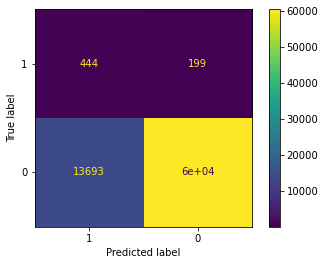

In [16]:
outputs = True
dt_predicted = dt_pipe.predict(X_test)
confusion = confusion_matrix(y_test, dt_predicted, labels = [1,0])
if outputs:
    print('Decision Tree (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()
    
    

Random Forest (best model)
 [[  407   236]
 [11899 62293]]


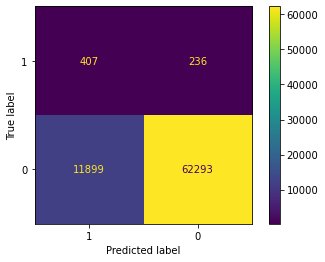

In [17]:
outputs = True
rf_predicted = rf_pipe.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted, labels = [1,0])
if outputs:
    print('Random Forest (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()